In [1]:
from dirty_cat.datasets import fetch_employee_salaries, fetch_drug_directory
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

In [2]:
ds = fetch_employee_salaries()
#ds = fetch_drug_directory()


In [3]:
X_original, y_original = ds.X, ds.y
# limit to 10K samples
X_original = X_original[:10000]
y_original = y_original[:10000]

In [4]:
column_to_consider = "employee_position_title"

In [5]:
# Dropping NA rows in X_original based on specified columns
#X_original = X_original.dropna(subset=["gender", column_to_consider, "year_first_hired"])
X_original, y_original = X_original.reset_index(drop=True), y_original.reset_index(drop=True)
X_original = X_original.dropna(subset=[column_to_consider])

# Keeping only the rows in y_original that correspond to the remaining rows in X_original
y_original = y_original.loc[X_original.index]

# label encoding
#y_original = y_original.astype('category')
#y_original = y_original.cat.codes
y_original = y_original > np.median(y_original)

# shuffle
indices = np.arange(len(X_original))
np.random.shuffle(indices)
X_original = X_original.iloc[indices]
y_original = y_original.iloc[indices]



In [6]:
X_original

,gender,department,department_name,division,assignment_category,employee_position_title,underfilled_job_title,date_first_hired,year_first_hired
1234,M,POL,Department of Police,PSB 4th District Patrol,Fulltime-Regular,Police Officer III,NaN,01/14/2008,2008
7745,M,POL,Department of Police,MSB Training and Education Division,Fulltime-Regular,Police Officer Candidate,NaN,07/11/2016,2016
2978,M,DGS,Department of General Services,Fleet Management Administration,Fulltime-Regular,Equipment Services Coordinator,NaN,05/31/2005,2005
285,M,POL,Department of Police,PSB 3rd District Patrol,Fulltime-Regular,Police Officer III,NaN,07/12/2010,2010
8928,M,DLC,Department of Liquor Control,Beer Delivery Operations,Fulltime-Regular,Truck Driver Helper/Warehouse Worker,NaN,08/31/2005,2005
...,...,...,...,...,...,...,...,...,...
338,F,HHS,Department of Health and Human Services,Contract Team,Fulltime-Regular,Office Services Coordinator,NaN,10/17/1994,1994
7131,M,DOT,Department of Transportation,Transit Silver Spring Ride On,Fulltime-Regular,Bus Operator,NaN,04/04/2016,2016
7205,F,DLC,Department of Liquor Control,"Licensure, Regulation and Education",Fulltime-Regular,Program Manager II,NaN,11/09/2009,2009
5089,F,HHS,Department of Health and Human Services,Care Coordination,Fulltime-Regular,Community Health Nurse II,NaN,06/13/2005,2005


In [7]:
!nvidia-smi

Fri Sep 29 16:28:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   41C    P0    36W / 250W |   1941MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to GPU
model.to('cuda')

# Sample data: list of column_to_consider
employee_position_titles = X_original[column_to_consider].tolist()

# Function to get BERT embeddings
def get_bert_embedding(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
    
    # Move the inputs to GPU
    inputs = {name: tensor.to('cuda') for name, tensor in inputs.items()}
    
    with torch.no_grad():  # Deactivates autograd, reducing memory usage and speeding up computations
        outputs = model(**inputs)
        
    # Using the [CLS] token embedding as sentence embedding
    sentence_embeddings = outputs.last_hidden_state[:, 0, :].cpu().detach().numpy()
    return sentence_embeddings

# Batch the titles (you can adjust the batch size based on your GPU's capabilities)
batch_size = 32  # Batch size of 2 as an example
batches = [employee_position_titles[i:i + batch_size] for i in range(0, len(employee_position_titles), batch_size)]

# Process the batches
all_embeddings = []
for batch in tqdm(batches):
    batch_embeddings = get_bert_embedding(batch)
    all_embeddings.append(batch_embeddings)

# Combine the batches back into a single array
final_embeddings = np.vstack(all_embeddings)


100%|██████████| 289/289 [00:03<00:00, 76.70it/s]


In [39]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-uncased')
final_embeddings = model.encode(employee_position_titles, show_progress_bar=True)

No sentence-transformers model found with name /home/soda/lgrinszt/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.


Batches:   0%|          | 0/289 [00:00<?, ?it/s]

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
class FirstNFeaturesExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1):
        self.n_features = n_features

    def fit(self, X, y=None):
        return self  # Nothing to fit, so return self

    def transform(self, X):
        # Extract the first n_features
        return X[:, :self.n_features]

In [41]:
from sklearn.model_selection import BaseCrossValidator
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np

from sklearn.model_selection import BaseCrossValidator
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np
import time

class FixedSizeSplit(BaseCrossValidator):
    """Cross-validator providing train/test indices to split data in train/test sets.
    
    Parameters:
    -----------
    n_train : int
        Number of samples to include in each training set.
    n_splits : int, optional (default=5)
        Number of splitting iterations.
    random_state : int, RandomState instance, default=None
        Random state for shuffling the data before splitting.
    """
    
    def __init__(self, n_train: int, n_splits: int = 5, random_state: int = None) -> None:
        self.n_train = n_train
        self.n_splits = n_splits
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None) -> int:
        return self.n_splits

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        
        if self.n_train > n_samples:
            raise ValueError(f"Cannot set n_train={self.n_train} greater than the"
                             f" number of samples: {n_samples}.")

        n_test = n_samples - self.n_train

        indices = np.arange(n_samples)
        
        rng = np.random.default_rng(self.random_state)
        
        for i in range(self.n_splits):
            indices_copy = indices.copy()
            rng.shuffle(indices)
            
            # Create train and test based on shuffled indices
            train = indices_copy[:self.n_train]
            test = indices_copy[self.n_train:]
            
            yield train, test


In [42]:
#### PCA ####
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from dirty_cat import MinHashEncoder
from tabpfn import TabPFNClassifier
from tqdm import tqdm
pca = PCA(n_components=10)
# create a transformer which takes the first n dimensions of a vector
extractor = FirstNFeaturesExtractor(n_features=10)
preprocessings = [extractor, pca, "passthrough"]
preprocessings_names = ["extractor", "pca", "passthrough"]


models = [LogisticRegression(), GradientBoostingClassifier(), TabPFNClassifier()]
model_names = ["LogisticRegression", "GradientBoostingClassifier", "TabPFNClassifier"]

results = {}

for model, model_name in tqdm(zip(models, model_names)):
    for preprocessing, preprocessing_name in tqdm(zip(preprocessings, preprocessings_names)):
        if preprocessing_name == "passthrough" and model_name != "LogisticRegression":
            continue
        pipe = Pipeline(steps=[('preprocessing', preprocessing), ('model', model)])
        cv = FixedSizeSplit(n_train=1000, n_splits=5)
        scores = cross_validate(pipe, final_embeddings, y_original, cv=cv, scoring='accuracy', n_jobs=5, verbose=1)
        print(scores)
        print(f"{model_name} / {preprocessing_name}: {np.mean(scores['test_score'])}")
        results[f"{model_name} / {preprocessing_name}"] = scores['test_score']

minhash = MinHashEncoder()

for model, model_name in zip(models, model_names):
    pipe = Pipeline(steps=[('preprocessing', minhash), ('model', model)])
    cv = FixedSizeSplit(n_train=1000, n_splits=5)
    scores = cross_validate(pipe, np.array(X_original[column_to_consider]).reshape(-1, 1), y_original, cv=cv, scoring='accuracy', n_jobs=5, verbose=1)
    print(f"{model_name} / minhash: {np.mean(scores['test_score'])}")
    results[f"{model_name} / minhash"] = scores['test_score']


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


0it [00:00, ?it/s][Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


{'fit_time': array([0.0269289 , 0.02137542, 0.01541901, 0.01462841, 0.01315641]), 'score_time': array([0.00360727, 0.0026269 , 0.00218391, 0.00223923, 0.00167847]), 'test_score': array([0.63150219, 0.61533787, 0.65082645, 0.63684978, 0.63770053])}
LogisticRegression / extractor: 0.6344433641225085


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


{'fit_time': array([0.08231664, 0.10161376, 0.03669953, 0.10465312, 0.06897902]), 'score_time': array([0.03439307, 0.03434038, 0.02091384, 0.02084112, 0.03851318]), 'test_score': array([0.62019932, 0.67805056, 0.63125912, 0.60792416, 0.65374332])}
LogisticRegression / pca: 0.638235294117647


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

{'fit_time': array([0.07453012, 0.10928869, 0.08258939, 0.09981871, 0.11018658]), 'score_time': array([0.01858425, 0.01937985, 0.02544498, 0.01928639, 0.02230453]), 'test_score': array([0.82073408, 0.82061254, 0.82474477, 0.82486631, 0.82875547])}
LogisticRegression / passthrough: 0.8239426349052017


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


{'fit_time': array([0.21062875, 0.26373291, 0.26775551, 0.22090697, 0.21559763]), 'score_time': array([0.01058054, 0.01116824, 0.01165152, 0.01067066, 0.01053309]), 'test_score': array([0.81599417, 0.80979582, 0.82049101, 0.81234808, 0.8117404 ])}
GradientBoostingClassifier / extractor: 0.814073894020418


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.4s finished
3it [00:01,  2.27it/s]
2it [00:03,  1.80s/it]

{'fit_time': array([0.22523975, 0.29053521, 0.28044295, 0.24014425, 0.33064508]), 'score_time': array([0.02632046, 0.03348637, 0.0307343 , 0.0285902 , 0.03016973]), 'test_score': array([0.78597472, 0.80238211, 0.8174526 , 0.81344191, 0.80566359])}
GradientBoostingClassifier / pca: 0.804982984929509


Loading model that can be used for inference only


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   28.5s remaining:   42.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   29.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


{'fit_time': array([0.01054192, 0.00854945, 0.00861955, 0.00823069, 0.00848413]), 'score_time': array([21.15604949, 19.06405044, 21.53134584, 21.55733156, 21.21239161]), 'test_score': array([0.81368498, 0.80712202, 0.81806028, 0.81806028, 0.81234808])}
TabPFNClassifier / extractor: 0.8138551288283908
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fo

[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.2s remaining:   36.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.9s finished
3it [00:56, 18.89s/it]
3it [01:00, 20.16s/it]
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/dirty_cat/_check_dependencies.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/dirty_cat/_check_dependencies.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/dirty_cat/_check_dependencies.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_reso

{'fit_time': array([0.04567003, 0.04112315, 0.08541679, 0.05270815, 0.08857322]), 'score_time': array([19.78196359, 19.69462132, 21.97305131, 20.18543434, 20.44229078]), 'test_score': array([0.82255712, 0.82231405, 0.81125425, 0.80213904, 0.82365095])}
TabPFNClassifier / pca: 0.8163830821584833


/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resourc

LogisticRegression / minhash: 0.7422216820612542


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


GradientBoostingClassifier / minhash: 0.8143655809431211
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   21.4s remaining:   32.1s


TabPFNClassifier / minhash: 0.8174039863879436


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   23.7s finished


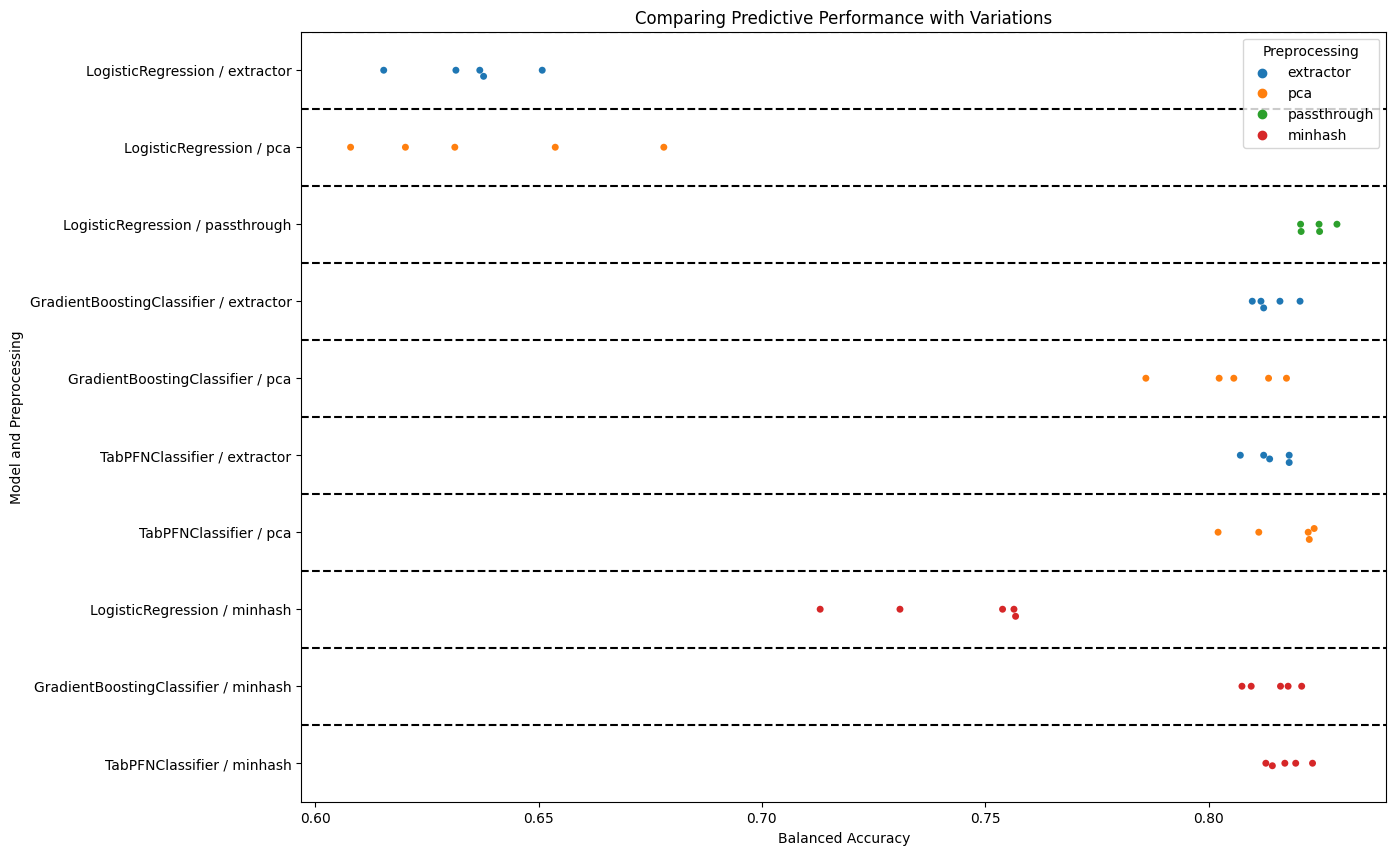

In [43]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Your existing code for generating results
# ...

# Prepare data for plotting
labels = []
acc_values = []

for key, values in results.items():
    for value in values:
        labels.append(key)
        acc_values.append(value)

# Create a DataFrame
df = pd.DataFrame({
    'Model and Preprocessing': labels,
    'Balanced Accuracy': acc_values,
    "Preprocessing": [e.split(" / ")[1] for e in labels]
})

# Create the plot
plt.figure(figsize=(14, 10))
sns.swarmplot(x='Balanced Accuracy', y='Model and Preprocessing', hue="Preprocessing", data=df)
#horizontal lines for each model
for i in range(len(np.unique(labels))):
    plt.axhline(i - 0.5, color='black', linestyle='--')

plt.title('Comparing Predictive Performance with Variations')
plt.show()


In [15]:
results

{'HistGradientBoostingClassifier / extractor': array([0.58768682, 0.58768682, 0.58768682, 0.58768682, 0.58768682]),
 'HistGradientBoostingClassifier / pca': array([0.57122423, 0.57153275, 0.5724028 , 0.57013824, 0.56824601]),
 'LogisticRegression / extractor': array([0.30883481, 0.30883481, 0.30883481, 0.30883481, 0.30883481]),
 'LogisticRegression / pca': array([0.24360904, 0.24360904, 0.24236198, 0.24444041, 0.24360904]),
 'LogisticRegression / passthrough': array([0.43465766, 0.43465766, 0.43465766, 0.43465766, 0.43465766]),
 'GradientBoostingClassifier / extractor': array([0.46485279, 0.47189143, 0.46619167, 0.46582523, 0.4659076 ]),
 'GradientBoostingClassifier / pca': array([0.3830631 , 0.43083913, 0.39122908, 0.46216488, 0.38801575]),
 'TabPFNClassifier / extractor': array([0.46672189, 0.46672189, 0.46672189, 0.46672189, 0.46672189]),
 'TabPFNClassifier / pca': array([0.25772344, 0.25772344, 0.25772344, 0.25772344, 0.25772344]),
 'HistGradientBoostingClassifier / minhash': array

## Directly finetune Bert

In [19]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Your text data and labels (replace these with your actual data and labels)
texts = X_original[column_to_consider].tolist()
#labels = (y_original > np.median(y_original)).tolist()
labels = y_original.tolist()

# Tokenize the text data
encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

#dataset = CustomDataset(encoding, torch.tensor(labels).long().reshape(-1, 1))

# Split dataset
train_size = 1000#int(0.8 * len(dataset))
#val_size = len(dataset) - train_size
train_dataset = CustomDataset(encoding[:1000], torch.tensor(labels).long().reshape(-1, 1)[:1000])
val_dataset = CustomDataset(encoding[1000:], torch.tensor(labels).long().reshape(-1, 1)[1000:])
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Initialize model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    num_train_epochs=10,
    logging_steps=100,
    logging_dir="./logs",
    output_dir="./results",
    evaluation_strategy="steps",
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
#model.save_pretrained("./fine_tuned_bert")

# Now you can use this fine-tuned model for your specific tasks


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/scratch/lgrinszt/micromamba/envs/dpo/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: leogrin. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy
100,0.779600,0.430642,0.799708
200,0.494200,0.555901,0.776616
300,0.416100,0.391750,0.789742
400,0.411600,0.469391,0.809553
500,0.425600,0.372725,0.816845
600,0.365900,0.456947,0.809431
700,0.379700,0.398222,0.823043
800,0.345500,0.406939,0.783179
900,0.337200,0.409160,0.826568
1000,0.326200,0.399998,0.823408


TrainOutput(global_step=1250, training_loss=0.40563882904052734, metrics={'train_runtime': 167.1088, 'train_samples_per_second': 59.841, 'train_steps_per_second': 7.48, 'total_flos': 61669422000000.0, 'train_loss': 0.40563882904052734, 'epoch': 10.0})

In [ ]:
from dirty_cat import MinHashEncoder
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize MinHashEncoder
encoder = MinHashEncoder()

X_enc = encoder.fit_transform(np.array(X_original[column_to_consider]).reshape(-1, 1))
#y = np.array((y_original > np.median(y_original))).astype(int)
y = y_original
print(X_enc.shape)
print(y.shape)
X_train, y_train = X_enc[:1000], y[:1000]
X_test, y_test = X_enc[1000:], y[1000:]

# Initialize HistGradientBoostingClassifier
model = HistGradientBoostingClassifier()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
model.score(X_test, y_test)


## Finetune Bert with TabPFN on top

In [ ]:
# create a new model
import torch.nn as nn
import torch
from tabpfn import TabPFNClassifier
# import Bert small model
from transformers import AutoModel
class BertAndTabPFN(nn.Module):
    def __init__(self, linear_translator=False, dim_tabpfn=100, preprocess_before_tabpfn=False):
        super().__init__()
        #self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert = AutoModel.from_pretrained("prajjwal1/bert-tiny")
        self.tabpfn = TabPFNClassifier().model[2]
        # no requires_grad for the tabpfn
        for param in self.tabpfn.parameters():
            param.requires_grad = False
        self.dim_tabpfn = dim_tabpfn
        self.preprocess_before_tabpfn = preprocess_before_tabpfn
        if linear_translator:
            self.linear_translator = nn.Linear(768, dim_tabpfn)
    
    def forward(self, input_ids, attention_mask, y, tabular_data=None, single_eval_pos=100):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        bert_embeddings = bert_outputs.last_hidden_state[:, 0, :]
        if hasattr(self, 'linear_translator'):
            tabpfn_input = self.linear_translator(bert_embeddings)
        else:
            tabpfn_input = bert_embeddings[:, :self.dim_tabpfn]
        tabpfn_input = tabpfn_input.reshape(tabpfn_input.shape[0], 1, tabpfn_input.shape[1])
        if self.preprocess_before_tabpfn:
            tabpfn_input = preprocess_input(tabpfn_input, y, single_eval_pos, preprocess_transform="none", device=input_ids.device)
        tabpfn_outputs = self.tabpfn((tabpfn_input, y), single_eval_pos=single_eval_pos)
        return tabpfn_outputs
    




In [ ]:
texts = X_original[column_to_consider].tolist()[:200]
#y = torch.tensor((y_original > np.median(y_original)).tolist()[:200]).reshape(-1, 1).float()
y = torch.tensor(y_original.tolist()[:200]).reshape(-1, 1).float()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids, attention_mask = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")['input_ids'], tokenizer(texts, padding=True, truncation=True, return_tensors="pt")['attention_mask']
input_ids = input_ids.to('cuda')
attention_mask = attention_mask.to('cuda')
y = y.to('cuda')
model = BertAndTabPFN().to('cuda')
model(input_ids, attention_mask, y=y, single_eval_pos=50)

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score
from utils import preprocess_input

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Your text data and labels (replace these with your actual data and labels)
# Your text data and labels (replace these with your actual data and labels)
texts = X_original[column_to_consider].tolist()
#labels = (y_original > np.median(y_original)).tolist()
labels = y_original.tolist()

# Tokenize the text data
encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset and dataloaders
#dataset = CustomDataset(encoding, torch.tensor(labels).float().reshape(-1, 1))
#print(f"Dataset size: {len(dataset)}")
train_size = 1000
val_size = 1000 #TODO
#test_size = len(dataset) - train_size - val_size
#print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
train_dataset = CustomDataset(encoding[:train_size], torch.tensor(labels).float().reshape(-1, 1)[:train_size])
val_dataset = CustomDataset(encoding[train_size:train_size+val_size], torch.tensor(labels).float().reshape(-1, 1)[train_size:train_size+val_size])
test_dataset = CustomDataset(encoding[train_size+val_size:], torch.tensor(labels).float().reshape(-1, 1)[train_size+val_size:])
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Initialize model and optimizer
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = BertAndTabPFN(preprocess_before_tabpfn=True, linear_translator=False).to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    ###########
    # Train loop
    model.train()
    for batch in train_loader:
        input_ids_train = batch['input_ids']
        attention_mask_train = batch['attention_mask']
        labels_train = batch['labels']
        # move the inputs to GPU
        input_ids_train = input_ids_train.to('cuda')
        attention_mask_train = attention_mask_train.to('cuda')
        labels_train = labels_train.to('cuda')
        single_eval_pos = 500
        output = model(input_ids_train, attention_mask=attention_mask_train, y=labels_train, single_eval_pos=single_eval_pos).squeeze()
        loss = nn.CrossEntropyLoss()(output, labels_train[single_eval_pos:].long().reshape(-1))
        if epoch > 0:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # compute train accuracy
        preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
        train_accuracy = accuracy_score(labels_train[single_eval_pos:].cpu().detach().numpy().reshape(-1), preds)
        print(f"Epoch {epoch + 1} - Training loss: {loss}, Training accuracy: {train_accuracy}")
    # Validation loop
    model.eval()
    val_preds, val_labels, val_losses = [], [], []
    best_val_loss = np.inf
    with torch.no_grad():
        for batch in val_loader: #TODO: remove the useless for loop
            input_ids_val = batch['input_ids']
            attention_mask_val = batch['attention_mask']
            labels_val = batch['labels']
            # move the inputs to GPU
            input_ids_val = input_ids_val.to('cuda')
            attention_mask_val = attention_mask_val.to('cuda')
            labels_val = labels_val.to('cuda')
            # concatenate train and val
            #TODO: make sure this is correct, no leak etc
            # maybe safer to create a TabPFNClassifier with the same parameters as the one in BertAndTabPFN
            input_ids = torch.cat((input_ids_train, input_ids_val), axis=0)
            attention_mask = torch.cat((attention_mask_train, attention_mask_val), axis=0)
            labels = torch.cat((labels_train, labels_val), axis=0)
            single_eval_pos = 1000
            output = model(input_ids, attention_mask=attention_mask, y=labels, single_eval_pos=single_eval_pos).squeeze()
            val_loss = nn.CrossEntropyLoss()(output, labels[single_eval_pos:].long().reshape(-1))
            if val_loss < best_val_loss:
                print(f"New best validation loss: {val_loss}")
                best_val_loss = val_loss
                # save the model
                torch.save(model.state_dict(), "checkpoints/model.pt")
                # save input_ids_train, attention_mask_train, labels_train
                torch.save(input_ids_train, "checkpoints/input_ids_train.pt")
                torch.save(attention_mask_train, "checkpoints/attention_mask_train.pt")
                torch.save(labels_train, "checkpoints/labels_train.pt")


            val_losses.append(val_loss.cpu())
            preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
            val_preds.append(preds)
            val_labels.append(labels[single_eval_pos:].cpu().detach().numpy().reshape(-1))
    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)
    val_losses = np.mean(val_losses)
    print(f"Epoch {epoch + 1} - Validation loss: {val_losses}")
    # Compute accuracy
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch + 1} - Validation accuracy: {val_accuracy}")

# Load the best model
model.load_state_dict(torch.load("checkpoints/model.pt"))
input_ids_train = torch.load("checkpoints/input_ids_train.pt")
attention_mask_train = torch.load("checkpoints/attention_mask_train.pt")
labels_train = torch.load("checkpoints/labels_train.pt")

# Test loop
model.eval()
test_preds, test_labels, test_losses = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids_test = batch['input_ids']
        attention_mask_test = batch['attention_mask']
        labels_test = batch['labels']
        # move the inputs to GPU
        input_ids_test = input_ids_test.to('cuda')
        attention_mask_test = attention_mask_test.to('cuda')
        labels_test = labels_test.to('cuda')
        # concatenate train and val
        #TODO put this back
        #input_ids = torch.cat((input_ids_train, input_ids_test), axis=0)
        #attention_mask = torch.cat((attention_mask_train, attention_mask_test), axis=0)
        #labels = torch.cat((labels_train, labels_test), axis=0)
        single_eval_pos = 1000

        output = model(input_ids_test, attention_mask=attention_mask_test, y=labels_test, single_eval_pos=single_eval_pos).squeeze()
        test_loss = nn.CrossEntropyLoss()(output, labels_test[single_eval_pos:].long().reshape(-1))
        test_losses.append(test_loss.cpu())
        preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
        test_preds.append(preds)
        test_labels.append(labels_test[single_eval_pos:].cpu().detach().numpy().reshape(-1))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)
test_losses = np.mean(test_losses)
print(f"Test loss: {test_losses}")
print(f"Test accuracy: {accuracy_score(test_labels, test_preds)}")

# Save the model
# model.save_pretrained("./fine_tuned_bert")


In [ ]:
np.unique(test_labels, return_counts=True)

In [ ]:
np.unique(test_preds, return_counts=True)